# Demonstration of accessing data in V2 of global MCS database

This notebook demonstrates how to access and perform simple analysis on V2 of the global MCS database. It gives example code of the basic methods of loading the data using `xarray`, for both the tracks data and the pixel-level data, as well as linking the two together. Some simple analysis is done.

* Database as in Feng et al. (2021), but with full global analysis (i.e., not split into three regions).
* Tracking as documented in the PyFLEXTRKR V2 document.

## Acronyms

* MCS: mesoscale convective system.
* CCS: cold cloud system - the result of the PyFLEXTRKR algorithm. Often close to the 241K brightness temperature threshold but extended in the presence of precipitation.
* PF: precipitation feature.

## Accessing tracks data

The MCS tracks are the result of applying the PyFLEXTRKR algorithm to the NASA Global Merged IR V1 infrared brightness temperature (Janowiak et al., 2017) and GPM IMERG V06B precipitation (Tan et al., 2019) datasets. The stored tracks are the *robust* MCS tracks: ones that have met the criteria set out in Feng et al. (2021), with lifetime-dependent thresholds on PF area, mean rainrate, rainrate skewness, and heavy rain ratio. The have also had both tropical cyclones and atmospheric rivers filtered out.

### Tracks data files

The MCS tracks dataset consist of NetCDF4 files. These are laid out as 1D, 2D and 3D arrays of data, with the main coordinate being `tracks`, and variable length data stored in a fixed length array (using a maximum duration of 400, equivalent to an MCS that last for 400 hr). A consequence of this is that all the data over the duration of the length of a given MCS will be NaNs or similar, and so the compression ratio of files on disk is very high. Hence, even though a file for a given year is only approximately 270MB on disk, its size in memory will be far larger. Fully loading one year using `xr.load_dataset` uses approximately 16G of memory. It is therefore sensible to use `xr.open_dataset` or `xr.open_mfdataset`, which access the dataset's metadata but do not load its data until they are needed.

Note, the compression level of a field can be seen from `xarray.Dataset`: `dstracks.area.encoding`. The tracks dataset is compressed using compression level 4.

### Using `xarray` to access data

`xarray` is a convenient way of loading the NetCDF4 files in Python. Fields can generally be manipulated using `xarray` methods or by loading the values a `numpy` arrays and manipulating those. This notebook requires having the following Python packages correctly installed (using e.g. `conda`). 

In [1]:
import datetime as dt
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.geodesic
import dask
from IPython.display import clear_output
import matplotlib as mpl
import matplotlib.pyplot as plt
# Use for .mp4 video:
# plt.rcParams["animation.html"] = "html5"
# Use for javascript animation:
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
# Edit these based on where these are on your system.
statsdir = Path('/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/stats')
pixeldir = Path('/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/mcstracking')

In [3]:
stats_paths = sorted(statsdir.glob('mcs_tracks_final_extc_????????.0000_????????.0000.nc'))
print(stats_paths[0])
print(stats_paths[-1])

/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/stats/mcs_tracks_final_extc_20000601.0000_20010101.0000.nc
/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/stats/mcs_tracks_final_extc_20200101.0000_20210101.0000.nc


In [4]:
# A single year can be opened using:
dstracks_2020 = xr.open_dataset(stats_paths[-1])

In [5]:
# Open the full dataset - 2000/06 to 2021/12.
# Note, this does not load the data - that will happen once `.load()` is called on a field or it is accessed.
dstracks = xr.open_mfdataset(
    stats_paths,
    concat_dim="tracks",
    combine="nested",
    mask_and_scale=False,
)
# Each seperate file for each year defines its own index for tracks. Re-index with a global index.
dstracks["tracks"] = np.arange(0, dstracks.dims["tracks"], 1, dtype=int)

/tmp/ipykernel_646/2053357098.py:10: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dstracks["tracks"] = np.arange(0, dstracks.dims["tracks"], 1, dtype=int)


In [6]:
# The times have a small offset from the exact times -- e.g. 34500 ns off. Correct this.
def round_times_to_nearest_second(dstracks, fields):
    def remove_time_incaccuracy(t):
        # To make this an array operation, you have to use the ns version of datetime64, like so:
        return (np.round(t.astype(int) / 1e9) * 1e9).astype("datetime64[ns]")

    for field in fields:
        dstracks[field].load()
        tmask = ~np.isnan(dstracks[field].values)
        dstracks[field].values[tmask] = remove_time_incaccuracy(
            dstracks[field].values[tmask]
        )

In [17]:
dstracks = dstracks_2020


In [18]:
# Commented out because these are taking far too long now...
# round_times_to_nearest_second(dstracks_2020, ['base_time', 'start_basetime', 'end_basetime'])
round_times_to_nearest_second(dstracks, ['base_time', 'start_basetime', 'end_basetime'])
dstracks

<xarray.Dataset> Size: 20GB
Dimensions:                  (tracks: 32138, times: 400, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 257kB 0 1 2 3 ... 32135 32136 32137
  * times                    (times) int64 3kB 0 1 2 3 4 ... 395 396 397 398 399
  * mergers                  (mergers) int64 400B 0 1 2 3 4 5 ... 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 24B 0 1 2
Data variables: (12/55)
    track_duration           (tracks) int32 129kB ...
    start_status             (tracks) float64 257kB ...
    end_status               (tracks) float64 257kB ...
    start_basetime           (tracks) datetime64[ns] 257kB 2020-01-01T00:30:0...
    end_basetime             (tracks) datetime64[ns] 257kB 2020-01-01T11:30:0...
    start_split_cloudnumber  (tracks) float64 257kB ...
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 103MB ...
    movement_distance        (tracks, times) float32 51MB ...
    movement_speed           (tracks, times) float32 51MB ...
    movement_theta           (tracks, times) float32 51MB ...
    movement_distance_x      (tracks, times) float32 51MB ...
    movement_distance_y      (tracks, times) float32 51MB ...
Attributes: (12/23)
    Title:                       Statistics of each MCS track
    Institution:                 Pacific Northwest National Laboratory
    Contact:                     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                  Wed Mar  9 03:42:36 2022
    startdate:                   20200101.0000
    enddate:                     20210101.0000
    ...                          ...
    PF_PF_min_majoraxis_thresh:  20
    coefs_pf_area:               [2874.05    89.825]
    coefs_pf_rr:                 [3.01657   0.0144461]
    coefs_pf_skew:               [0.194462  0.0100072]
    coefs_pf_heavyratio:         [3.419024 0.438709]
    max_speed_thresh:            50

`dstracks` is an `xarray.Dataset`. You can access its fields using e.g. `dstracks.base_time`.

In [19]:
# Note, times that start 1969 are equivalent to nans.
dstracks.base_time

<xarray.DataArray 'base_time' (tracks: 32138, times: 400)> Size: 103MB
array([['2020-01-01T00:30:00.000000000', '2020-01-01T01:30:00.000000000',
        '2020-01-01T02:30:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2020-01-01T00:30:00.000000000', '2020-01-01T01:30:00.000000000',
        '2020-01-01T02:30:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2020-01-01T00:30:00.000000000', '2020-01-01T01:30:00.000000000',
        '2020-01-01T02:30:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ...,
       ['2020-12-31T17:30:00.000000000', '2020-12-31T18:30:00.000000000',
        '2020-12-31T19:30:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2020-12-31T18:30:00.000000000', '2020-12-31T19:30:00.000000000',
        '2020-12-31T20:30:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT'],
       ['2020-12-31T18:30:00.000000000', '2020-12-31T19:30:00.000000000',
        '2020-12-31T20:30:00.000000000', ...,
                                  'NaT',                           'NaT',
                                  'NaT']], dtype='datetime64[ns]')
Coordinates:
  * tracks   (tracks) int64 257kB 0 1 2 3 4 5 ... 32133 32134 32135 32136 32137
  * times    (times) int64 3kB 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
Attributes:
    long_name:  Epoch time of a feature

In [14]:
# Values can be accessed as a `numpy` array:
dstracks.area.values

array([[775200., 817000., 860800., ...,     nan,     nan,     nan],
       [588600., 556700., 590500., ...,     nan,     nan,     nan],
       [551800., 825800., 476000., ...,     nan,     nan,     nan],
       ...,
       [ 24300., 148300., 213200., ...,     nan,     nan,     nan],
       [ 32100., 119600., 190000., ...,     nan,     nan,     nan],
       [ 73800., 166600., 192800., ...,     nan,     nan,     nan]],
      dtype=float32)

The data values are laid out as follows. 

* Fields with only `tracks` as coords are single-valued for each track, e.g. `track_duration`.
* Fields with coords `(tracks, times)` are lifetime variables for that track, where the first `track_duration` have actual values.
  * E.g. `dstracks.areas`
* Fields with coords `(tracks, times, mergers)` are lifetime variables, where each time can have up to 50 `mergers` associated with it.
  * These are to do with the tracking of the clouds that merge/split into/from the MCS, e.g. `dstracks.merge_cloudnumber`
* Fields with coords `(tracks, times, nmaxpf)` are lifetime variables, where each time can have up to 3 `nmaxpf` associated with it.
  * These are properties of the up to 3 PFs associated with the cloud, e.g. `dstracks.pf_rainrate`


In [20]:
# Compression level info:
dstracks.area.encoding

{'dtype': dtype('float32'),
 'zlib': True,
 'szip': False,
 'zstd': False,
 'bzip2': False,
 'blosc': False,
 'shuffle': True,
 'complevel': 4,
 'fletcher32': False,
 'contiguous': False,
 'chunksizes': (1, 400),
 'preferred_chunks': {'tracks': 1, 'times': 400},
 'source': '/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/stats/mcs_tracks_final_extc_20200101.0000_20210101.0000.nc',
 'original_shape': (32138, 400),
 '_FillValue': nan}

### Selecting tracks

In [21]:
# A single track can be selected from its track number:
track = dstracks.sel(tracks=234)
track

<xarray.Dataset> Size: 613kB
Dimensions:                  (times: 400, mergers: 50, nmaxpf: 3)
Coordinates:
    tracks                   int64 8B 234
  * times                    (times) int64 3kB 0 1 2 3 4 ... 395 396 397 398 399
  * mergers                  (mergers) int64 400B 0 1 2 3 4 5 ... 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 24B 0 1 2
Data variables: (12/55)
    track_duration           int32 4B ...
    start_status             float64 8B ...
    end_status               float64 8B ...
    start_basetime           datetime64[ns] 8B 2020-01-03T12:30:00
    end_basetime             datetime64[ns] 8B 2020-01-04T07:30:00
    start_split_cloudnumber  float64 8B ...
    ...                       ...
    pf_mcsstatus             (times) float64 3kB ...
    movement_distance        (times) float32 2kB ...
    movement_speed           (times) float32 2kB ...
    movement_theta           (times) float32 2kB ...
    movement_distance_x      (times) float32 2kB ...
    movement_distance_y      (times) float32 2kB ...
Attributes: (12/23)
    Title:                       Statistics of each MCS track
    Institution:                 Pacific Northwest National Laboratory
    Contact:                     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                  Wed Mar  9 03:42:36 2022
    startdate:                   20200101.0000
    enddate:                     20210101.0000
    ...                          ...
    PF_PF_min_majoraxis_thresh:  20
    coefs_pf_area:               [2874.05    89.825]
    coefs_pf_rr:                 [3.01657   0.0144461]
    coefs_pf_skew:               [0.194462  0.0100072]
    coefs_pf_heavyratio:         [3.419024 0.438709]
    max_speed_thresh:            50

In [22]:
# You might want to select tracks based on e.g. the time at which they are active:
datetime = pd.Timestamp('2020-06-01 12:30').to_numpy()
# `isel` selects on index. The expression on the RHS collapses the 2D field of `base_time` into a 
# 1D boolean field that is true if *any* base_time for a given track matches `datetime`.
dstracks_at_time = dstracks.isel(
     tracks=(dstracks.base_time.values == datetime).any(axis=1)
)
dstracks_at_time

<xarray.Dataset> Size: 51MB
Dimensions:                  (tracks: 83, times: 400, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 664B 12396 12430 ... 12618 12619
  * times                    (times) int64 3kB 0 1 2 3 4 ... 395 396 397 398 399
  * mergers                  (mergers) int64 400B 0 1 2 3 4 5 ... 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 24B 0 1 2
Data variables: (12/55)
    track_duration           (tracks) int32 332B ...
    start_status             (tracks) float64 664B ...
    end_status               (tracks) float64 664B ...
    start_basetime           (tracks) datetime64[ns] 664B 2020-05-30T03:30:00...
    end_basetime             (tracks) datetime64[ns] 664B 2020-06-02T05:30:00...
    start_split_cloudnumber  (tracks) float64 664B ...
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 266kB ...
    movement_distance        (tracks, times) float32 133kB ...
    movement_speed           (tracks, times) float32 133kB ...
    movement_theta           (tracks, times) float32 133kB ...
    movement_distance_x      (tracks, times) float32 133kB ...
    movement_distance_y      (tracks, times) float32 133kB ...
Attributes: (12/23)
    Title:                       Statistics of each MCS track
    Institution:                 Pacific Northwest National Laboratory
    Contact:                     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                  Wed Mar  9 03:42:36 2022
    startdate:                   20200101.0000
    enddate:                     20210101.0000
    ...                          ...
    PF_PF_min_majoraxis_thresh:  20
    coefs_pf_area:               [2874.05    89.825]
    coefs_pf_rr:                 [3.01657   0.0144461]
    coefs_pf_skew:               [0.194462  0.0100072]
    coefs_pf_heavyratio:         [3.419024 0.438709]
    max_speed_thresh:            50

In [23]:
# Or access tracks based on their location:
# N.B. force a load of meanlat.
dstracks.meanlat.load()
# This suppresses a warning about chunk sizes.
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    dstracks_tropical = dstracks.isel(
        tracks=((dstracks.meanlat.values > -20) & (dstracks.meanlat.values < 20)).any(axis=1)
    )
dstracks_tropical

<xarray.Dataset> Size: 14GB
Dimensions:                  (tracks: 23118, times: 400, mergers: 50, nmaxpf: 3)
Coordinates:
  * tracks                   (tracks) int64 185kB 2 3 4 5 ... 32133 32134 32136
  * times                    (times) int64 3kB 0 1 2 3 4 ... 395 396 397 398 399
  * mergers                  (mergers) int64 400B 0 1 2 3 4 5 ... 45 46 47 48 49
  * nmaxpf                   (nmaxpf) int64 24B 0 1 2
Data variables: (12/55)
    track_duration           (tracks) int32 92kB ...
    start_status             (tracks) float64 185kB ...
    end_status               (tracks) float64 185kB ...
    start_basetime           (tracks) datetime64[ns] 185kB 2020-01-01T00:30:0...
    end_basetime             (tracks) datetime64[ns] 185kB 2020-01-01T20:30:0...
    start_split_cloudnumber  (tracks) float64 185kB ...
    ...                       ...
    pf_mcsstatus             (tracks, times) float64 74MB ...
    movement_distance        (tracks, times) float32 37MB ...
    movement_speed           (tracks, times) float32 37MB ...
    movement_theta           (tracks, times) float32 37MB ...
    movement_distance_x      (tracks, times) float32 37MB ...
    movement_distance_y      (tracks, times) float32 37MB ...
Attributes: (12/23)
    Title:                       Statistics of each MCS track
    Institution:                 Pacific Northwest National Laboratory
    Contact:                     Zhe Feng, zhe.feng@pnnl.gov
    Created_on:                  Wed Mar  9 03:42:36 2022
    startdate:                   20200101.0000
    enddate:                     20210101.0000
    ...                          ...
    PF_PF_min_majoraxis_thresh:  20
    coefs_pf_area:               [2874.05    89.825]
    coefs_pf_rr:                 [3.01657   0.0144461]
    coefs_pf_skew:               [0.194462  0.0100072]
    coefs_pf_heavyratio:         [3.419024 0.438709]
    max_speed_thresh:            50

In [24]:
# Each track can then be looped over using e.g.:
for track_id in dstracks_at_time.tracks.values[:10]:  # Just get first 10.
    track = dstracks_at_time.sel(tracks=track_id)
    print(track.tracks.values.item(), track.track_duration.values.item())

12396 75
12430 52
12440 55
12452 50
12482 39
12492 34
12494 31
12505 29
12511 35
12521 35


### Individual track properties

In [25]:
# Select a track.
track = dstracks.sel(tracks=234)

In [26]:
# Access some of the track's properties:
# Scalars can be accessed using:
duration = track.track_duration.values.item()  # `.values.item()` unpacks the value into an int (in this case).
print(f'track_duration: {duration}')
# For times, it is useful to convert from a np.datetime64[ns] to a pandas Timestamp object or native datetime object:
start_basetime = pd.Timestamp(track.start_basetime.values.item()).to_pydatetime()
print(f'start_basetime: {start_basetime}')

# Lifetime values can be accessed:
# Note, e.g. area values are nan after the duration of the track:
print(f'area (full): {track.area.values}')
# Slice based on duration:
print(f'area (sliced): {track.area.values[:duration]}')

track_duration: 20
start_basetime: 2020-01-03 12:30:00
area (full): [118800. 126200. 103000. 102900. 121600. 125000. 115700.  73200. 142100.
  97000.  99000.  98100.  96000. 132400. 134800. 116600. 105100.  40200.
  20200.  12000.     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan     nan     nan
     nan     nan     nan     nan     nan     nan     nan

In [27]:
# mergers data are 2D fields (with -9999 indicating no values for merger number N):
track.merge_cloudnumber.values[:duration, :]

array([[  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   n

In [28]:
# Similarly for PF data (with nan indicating no value):
track.pf_rainrate.values[:duration, :]

array([[ 7.2440414,        nan,        nan],
       [ 5.196    ,  6.2172174,  3.492887 ],
       [ 5.23674  ,  5.3213825,        nan],
       [ 7.337885 ,        nan,        nan],
       [ 7.930158 ,        nan,        nan],
       [ 7.3854966,        nan,        nan],
       [ 6.942014 ,        nan,        nan],
       [ 8.912208 ,        nan,        nan],
       [ 8.956444 ,  3.2623682,        nan],
       [11.471359 ,        nan,        nan],
       [10.289864 ,  4.3744335,        nan],
       [ 9.796599 ,  8.643371 ,        nan],
       [ 8.97403  ,  8.377659 ,  2.4474738],
       [ 6.50245  ,  5.8209224,  9.870709 ],
       [ 4.6167607,  6.191008 ,  4.727581 ],
       [ 5.4442706,  4.890694 ,  2.7229493],
       [ 4.4790983,  5.7590227,  2.9891665],
       [ 5.443607 ,  4.570531 ,  4.9076624],
       [ 6.3321257,        nan,        nan],
       [ 8.073594 ,        nan,        nan]], dtype=float32)

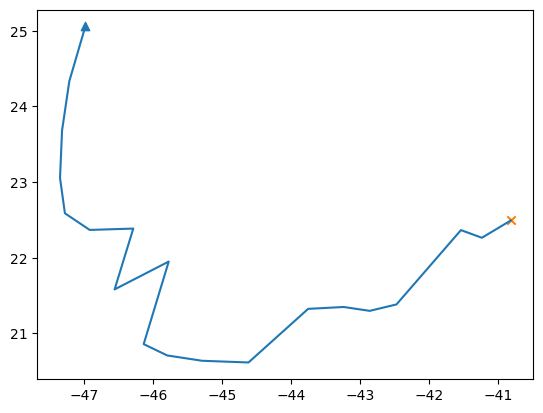

In [29]:
# A simple plot of the track's position can be made using:
plt.scatter(track.meanlon.values[0], track.meanlat.values[0], marker='^')  # Start point.
plt.scatter(track.meanlon.values[duration - 1], track.meanlat.values[duration - 1], marker='x')  # End point.
plt.plot(track.meanlon.values, track.meanlat.values);

In [30]:
def add_ccs_area_swath(ax, track, n_points=20):
    """Adds an area swath of the cold cloud system area, treating each CCS as a circle."""
    try:
        # N.B. these are optional dependencies.
        import shapely.geometry
        import shapely.ops
    except ImportError:
        print('shapely not installed')
        return
    duration = track.track_duration.values.item()
    time_indices = range(duration)
    
    # geoms will contain all the circles.
    geoms = []
    for i in time_indices:
        lon = track.meanlon.values[i]
        lat = track.meanlat.values[i]
        radius = np.sqrt(track.ccs_area.values[i] / np.pi) * 1e3
        circle_points = cartopy.geodesic.Geodesic().circle(
            lon=lon, lat=lat, radius=radius, n_samples=n_points, endpoint=False
        )
        geom = shapely.geometry.Polygon(circle_points)
        geoms.append(geom)
    # Combine all the circles into a CCS swath.
    full_geom = shapely.ops.unary_union(geoms)
    ax.add_geometries(
        (full_geom,),
        crs=cartopy.crs.PlateCarree(),
        facecolor="none",
        edgecolor="grey",
        linewidth=2,
    )

(<xarray.DataArray 'meanlon' ()> Size: 8B
 array(-47.34552765)
 Coordinates:
     tracks   int64 8B 234,
 <xarray.DataArray 'meanlon' ()> Size: 8B
 array(-40.81416702)
 Coordinates:
     tracks   int64 8B 234,
 <xarray.DataArray 'meanlat' ()> Size: 8B
 array(20.61572838)
 Coordinates:
     tracks   int64 8B 234,
 <xarray.DataArray 'meanlat' ()> Size: 8B
 array(25.0574913)
 Coordinates:
     tracks   int64 8B 234)

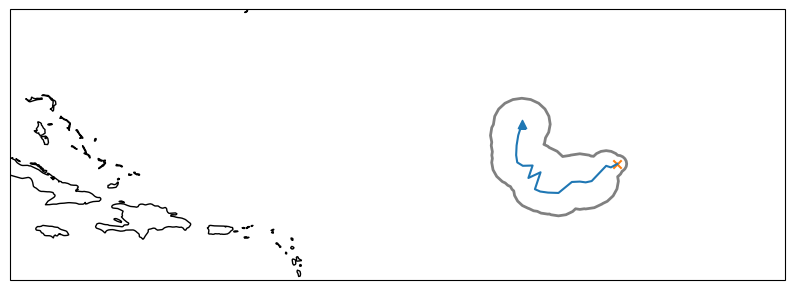

In [35]:
# Nicer figure using cartopy projections and showing a circle based on the CCS area.
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches((10, 5))
ax.coastlines()
ax.scatter(track.meanlon.values[0], track.meanlat.values[0], marker='^')
ax.scatter(track.meanlon.values[duration - 1], track.meanlat.values[duration - 1], marker='x')
ax.plot(track.meanlon.values, track.meanlat.values)
add_ccs_area_swath(ax, track)
ax.set_extent([-80, -30, 15, 30])
track.meanlon.min(), track.meanlon.max(), track.meanlat.min(), track.meanlat.max()

### Group properties of tracks

Group properties for lots of tracks can be easily calculated by accessing the fields on an `xarray.Dataset` that contains many tracks.

In [36]:
# mean track duration:
dstracks.track_duration.values.mean()

19.309073371087187

In [37]:
# Same thing using xarray:
dstracks.track_duration.mean().values.item()

19.309073371087187

In [38]:
# Tropical duration:
dstracks_tropical.track_duration.values.mean()

19.411843585085215

In [39]:
# Mean area for each track:
# `np.nanX` functions are useful for naturally dealing with the missing data.
mean_areas = np.nanmean(dstracks.area.values, axis=1)

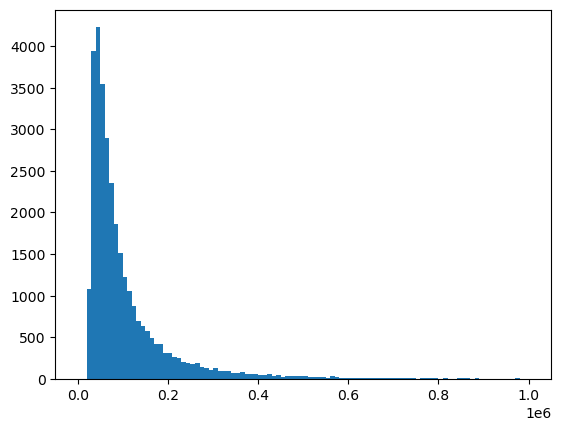

In [40]:
plt.hist(mean_areas, bins=np.linspace(0, 1e6, 101));

In [41]:
# Same thing using xarray:
xr_mean_areas = dstracks.area.mean(dim='times', skipna=True).values

In [42]:
(mean_areas == xr_mean_areas).all()

True

## Accessing pixel-level data

Pixel-level data is stored separately from the MCS tracks data. These files contain the raw brightness temperature (tb) and precipitation fields, as well as a derived cloudnumber field, which is the area covered by the CCS and can be linked to a given track (see below).

**NOTE** the values you get for this will depend on which files have been extracted from the \*.tar archives.

In [43]:
# It's useful to make a dict so that you can access each file by datetime:
track_pixel_paths = sorted(pixeldir.glob("**/*.nc"))
date_path_map = {
    dt.datetime.strptime(p.stem, "mcstrack_%Y%m%d_%H%M"): p
    for p in track_pixel_paths
}

In [44]:
# Only 2019 fully uncompressed so far:
list(date_path_map.items())[0]

(datetime.datetime(2000, 6, 1, 0, 30),
 PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/mcstracking/20000601.0000_20010101.0000/2000/06/01/mcstrack_20000601_0030.nc'))

In [45]:
list(date_path_map.items())[-1]

(datetime.datetime(2020, 12, 31, 23, 30),
 PosixPath('/gws/nopw/j04/mcs_prime/mmuetz/data/MCS_Global/mcstracking/20200101.0000_20210101.0000/2020/12/31/mcstrack_20201231_2330.nc'))

In [46]:
# Smaller datasets - load completely.
dsframe = xr.load_dataset(track_pixel_paths[123])
dsframe

<xarray.Dataset> Size: 311MB
Dimensions:                        (time: 1, lat: 1200, lon: 3600)
Coordinates:
  * time                           (time) datetime64[ns] 8B 2000-06-06T03:30:...
  * lat                            (lat) float32 5kB -59.95 -59.85 ... 59.95
  * lon                            (lon) float32 14kB -179.9 -179.9 ... 179.9
Data variables:
    base_time                      (time) datetime64[ns] 8B 2000-06-06T03:30:...
    longitude                      (lat, lon) float32 17MB -179.9 ... 179.9
    latitude                       (lat, lon) float32 17MB -59.95 ... 59.95
    tb                             (time, lat, lon) float32 17MB 272.0 ... 273.0
    precipitation                  (time, lat, lon) float32 17MB 0.0009731 .....
    cloudtype                      (time, lat, lon) float64 35MB nan nan ... nan
    cloudnumber                    (time, lat, lon) float64 35MB nan nan ... nan
    split_tracknumbers             (time, lat, lon) float64 35MB nan nan ... nan
    merge_tracknumbers             (time, lat, lon) float64 35MB nan nan ... nan
    cloudtracknumber_nomergesplit  (time, lat, lon) float64 35MB nan nan ... nan
    cloudtracknumber               (time, lat, lon) float64 35MB nan nan ... nan
    pcptracknumber                 (time, lat, lon) float64 35MB nan nan ... nan
Attributes:
    Title:                     Robust MCS pixel-level tracking data
    Contact:                   Zhe Feng: zhe.feng@pnnl.gov
    Created_on:                Fri Mar 18 09:41:31 2022
    startdate:                 20000601.0000
    enddate:                   20010101.0000
    precipitation_datasource:  imerg
    mcs_tb_area_thresh:        40000
    mcs_tb_duration_thresh:    4
    mcs_pf_majoraxis_thresh:   100
    mcs_pf_durationthresh:     4

In [47]:
def global_plot(dsframe, field, method='contourf', **kwargs):
    time = pd.Timestamp(round(dsframe.time.values.item() / 1e9) * 1e9)
    if 'cmap' not in kwargs and 'colors' not in kwargs:
        kwargs['cmap'] = 'jet'
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
    fig.set_size_inches((19, 5))
    ax.set_title(time)
    ax.coastlines()
    im = getattr(ax, method)(dsframe.longitude, dsframe.latitude, dsframe[field].isel(time=0), **kwargs)
    plt.colorbar(im)
    return fig, ax

cmap = mpl.cm.get_cmap('jet')

/tmp/ipykernel_646/3916667808.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('jet')


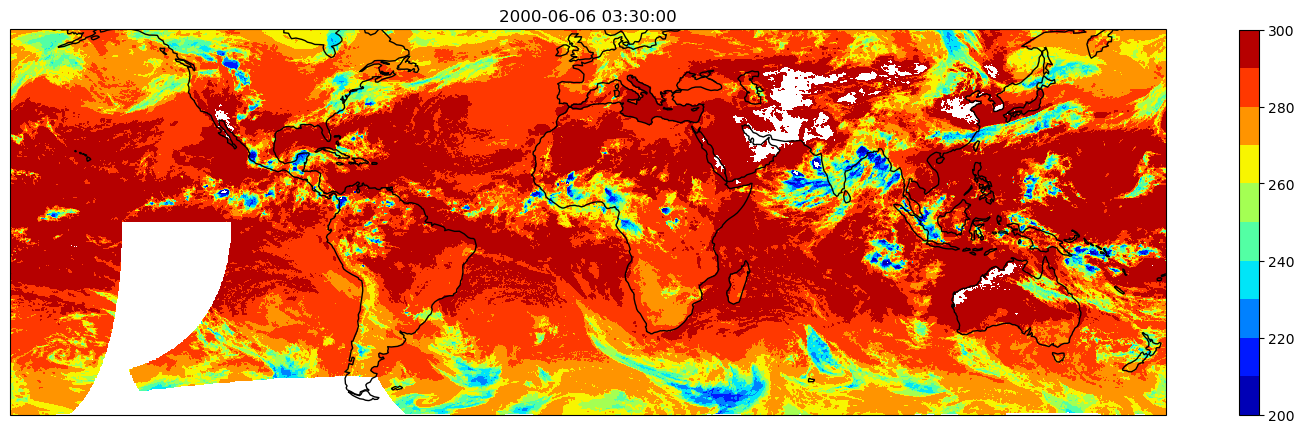

In [48]:
# Note the TB data are not complete. For 2019-03-06 03:30 - See the missing values stretching from Russia/Japan to south of Australia.
global_plot(dsframe, 'tb', levels=np.arange(200, 310, 10));

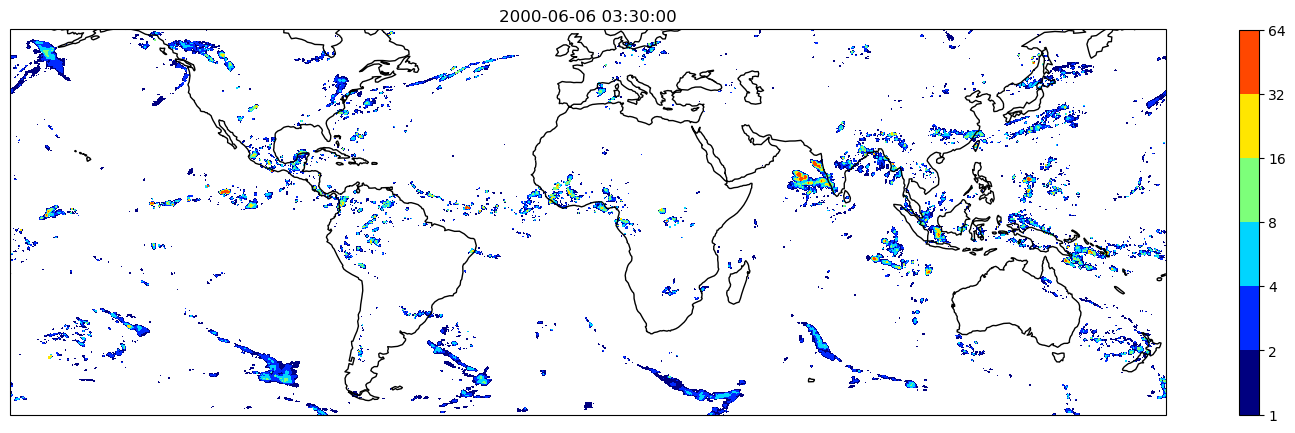

In [49]:
# Precipitation clearly more prevalent where TB low.
global_plot(dsframe, 'precipitation', levels=[1, 2, 4, 8, 16, 32, 64], colors=[cmap(v) for v in np.linspace(0, 1, 7)]);

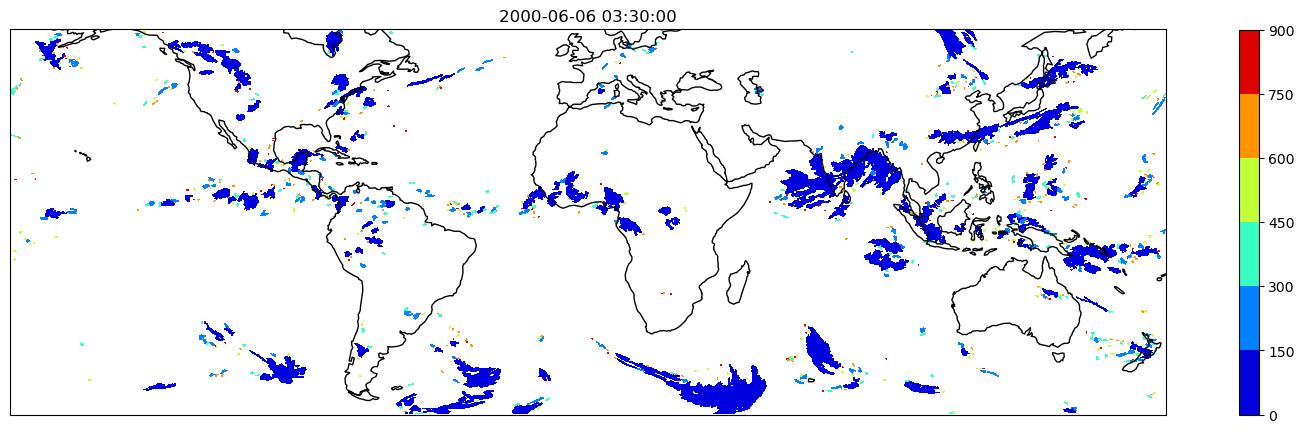

In [50]:
# This is a derived field, which is based on the TB thresh. and uses PF data to extend these areas (Feng et al. 2021).
global_plot(dsframe, 'cloudnumber');

## Linking tracks to pixel-level data

Every track contains a field with the values of the cloudnumber in the pixel-level data. This can be used to link each track to its pixel-level data, using the timestamp and the cloudnumber. The timestamp can be used to determine which pixel-level data file to load, and the cloudnumber references the equivalent field in the dataset (as shown in the figure above).

In [51]:
# Select a tropical track from July 2019, that lasted more than 20 hours and less than 40.
dates = pd.DatetimeIndex(dstracks_tropical.start_basetime.values)  # These containers make it easy to select on year, month...
track = dstracks_tropical.isel(tracks=(
    (dates.year == 2020) & 
    (dates.month == 7) & 
    (dstracks_tropical.track_duration > 20) & 
    (dstracks_tropical.track_duration < 40)
)).isel(tracks=0)  # just select first track that meets criteria.
duration = track.track_duration.values.item()
#duration = 2
# assert track.tracks.values.item() == 647749

In [52]:
# These can be used to work out which pixel-level data file to open.
track_dates = [pd.Timestamp(d).to_pydatetime() for d in track.base_time.values[:duration]]
track_dates

[datetime.datetime(2020, 7, 1, 1, 30), datetime.datetime(2020, 7, 1, 2, 30)]

In [53]:
# These values reference the `cloudnumber` field within the pixel-level data.
track.cloudnumber.values[:duration]

array([40., 36.])

In [54]:
%%capture
# Prev line ensures figure not shown until animation.fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
# Set up a figure to use for the animation below.

margin_degree = 10
minlon = track.meanlon.values[:duration].min()
maxlon = track.meanlon.values[:duration].max()
minlat = track.meanlat.values[:duration].min()
maxlat = track.meanlat.values[:duration].max()
aspect = (maxlon - minlon + 2 * margin_degree) / (maxlat - minlat + 2 * margin_degree)
fig.set_size_inches((18, 18 / aspect))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)

In [55]:
# Create an animation of the track, CCS, TB, and precip.
def plot_track_link_pixel(i):
    print(f'{i + 1}/{duration}')
    ax.clear()
    ax.set_extent((minlon - margin_degree, maxlon + margin_degree, minlat - margin_degree, maxlat + margin_degree))
    ax.coastlines()  

    date = track_dates[i]
    ax.set_title(date)
    # Get the cloudnumber to link to the pixel data.
    cn = track.cloudnumber.values[:duration][i]
    # Get the correct pixel-level dataset frame for the current time of the track.
    dsframe = xr.load_dataset(date_path_map[date])
    # Display pixel data.
    ax.contourf(dsframe.lon, dsframe.lat, dsframe.isel(time=0).precipitation, levels=[1, 2, 4, 8, 16, 32, 64], colors=[cmap(v) for v in np.linspace(0, 1, 7)])
    ax.contour(dsframe.lon, dsframe.lat, dsframe.isel(time=0).tb, levels=[241], colors=['grey'])
    # Here, only the values within the frame with the correct cloudnumber are True (==1).¶
    ax.contour(dsframe.lon, dsframe.lat, dsframe.isel(time=0).cloudnumber == cn, levels=[0.5], colors=['r'])
    # Display track path.
    ax.scatter(track.meanlon.values[0], track.meanlat.values[0], marker='^', c='r')
    ax.scatter(track.meanlon.values[duration - 1], track.meanlat.values[duration - 1], marker='x', c='r')
    ax.scatter(track.meanlon.values[i], track.meanlat.values[i], marker='o', c='r')
    ax.plot(track.meanlon.values, track.meanlat.values, 'r-')
    clear_output(wait=True)
    
anim = matplotlib.animation.FuncAnimation(fig, plot_track_link_pixel, frames=duration, interval=500)
anim

* Track: red line with circle showing its centroid.
* CCS: red outline.
* TB: grey contour at 241K (N.B. often coincides with CCS).
* precipitation: filled contours.
* This MCS track starts in Venezuela and travels west into Colombia.

### Merge/Split clouds from an MCS

There is more data in the track that links to the pixel-level data. In particular, the `merge_cloudnumber` and `split_cloudnumber` fields reference clouds that merge into, or split from, the tracked MCS. Remembering that the initial algorithm tracks **all** clouds above a certain size, and whether or not a particular track constitutes an MCS is only determined after the main tracking has taken place, this means that there is extra information about how an MCS grows and decays from these fields. A cloudnumber can be in both `merge_cloudnumber` and `split_cloudnumber`, meaning it has split from an MCS, but will merge back into it in due course.

In [56]:
%%capture
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
margin_degree = 5
aspect = (maxlon - minlon + 2 * margin_degree) / (maxlat - minlat + 2 * margin_degree)
fig.set_size_inches((18, 18 / aspect))
fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)

In [57]:
def plot_cloud_merge_split(i):
    print(f'{i + 1}/{duration}')

    cn = track.cloudnumber[i]
    ax.clear()
    ax.set_extent((minlon - margin_degree, maxlon + margin_degree, minlat - margin_degree, maxlat + margin_degree))
    ax.coastlines()  
    date = track_dates[i]

    dsframe = xr.open_dataset(date_path_map[date])
    dsframe.cloudnumber.load()

    ax.contour(dsframe.lon, dsframe.lat, dsframe.cloudnumber[0] == cn, levels=[0.5], colors=['k'])
    
    # Use Python sets so that it is easy to work out e.g. intersections.
    mcn = set(v for v in track.merge_cloudnumber.values[i] if ~np.isnan(v) and v != -9999)
    scn = set(v for v in track.split_cloudnumber.values[i] if ~np.isnan(v) and v != -9999)
    for cn in mcn & scn:
        # In both.
        ax.contour(dsframe.lon, dsframe.lat, dsframe.cloudnumber[0] == cn, levels=[0.5], colors=['purple'])
    for cn in mcn - scn:
        # Only in merge_cloudnumber.
        ax.contour(dsframe.lon, dsframe.lat, dsframe.cloudnumber[0] == cn, levels=[0.5], colors=['g'])
    for cn in scn - mcn:
        # Only in split_cloudnumber.
        ax.contour(dsframe.lon, dsframe.lat, dsframe.cloudnumber[0] == cn, levels=[0.5], colors=['r'])
    ax.scatter(track.meanlon.values[0], track.meanlat.values[0], marker='^', c='r')
    ax.scatter(track.meanlon.values[duration - 1], track.meanlat.values[duration - 1], marker='x', c='r')
    ax.scatter(track.meanlon.values[i], track.meanlat.values[i], marker='o', c='r')
    ax.plot(track.meanlon.values, track.meanlat.values, 'r-')
    clear_output(wait=True)
    
# anim = matplotlib.animation.FuncAnimation(fig, plot_cloud_merge_split, frames=duration, interval=500)
# anim

* Red line: path of MCS with circle showing its centroid
* Black: MCS CCS
* Green: clouds that will merge into MCS
* Red: clouds that have split from MCS
* Purple: clouds that have split from MCS and will merge back into it

### MCSs that start/end with splits/merges

It is possible for an MCS track to begin as the splitting of two clouds, or end with merging into another cloud. In these cases, this information is recorded in the track.

* Splits: if `track.start_split_cloudnumber` > 0, then the MCS track began as the split of a larger cloud. In some cases, the progenitor cloud could have been an MCS.
* Merges: if `track.end_merge_cloudnumber` > 0, then the MCS track ended as the merge of two clouds. In some cases, the merged cloud could be an MCS.

In [58]:
dstracks_2020.start_split_cloudnumber.load()
dstracks_2020.end_merge_cloudnumber.load()

ntracks = len(dstracks_2020.tracks)
nsplits = (dstracks_2020.start_split_cloudnumber.values > 0).sum()
nmerges = (dstracks_2020.end_merge_cloudnumber.values > 0).sum()

print(f'nsplits={nsplits} - {nsplits / ntracks * 100:.1f}%')
print(f'nmerges={nmerges} - {nmerges / ntracks * 100:.1f}%')

nsplits=11543 - 35.9%
nmerges=10682 - 33.2%


So about 1/3 MCS tracks start or end in a split/merge. These are splits/merges from clouds, not necessarily from other MCSs.

Finding if it split/merged from an MCS is a little more involved.

* Split: examine all `dstracks.cloudnumber` at t - 1hr, and see if they match the value of `track.start_split_cloudnumber`.
* Merge: examine all `dstracks.cloudnumber` at t + 1hr, and see if they match the value of `track.end_merge_cloudnumber`.

Code for these is shown next.

In [59]:
# N.B. This is very slow if done on the full dstracks dataset. Do for one year only.
dstracks_2020.start_split_cloudnumber.load()
dstracks_2020.end_merge_cloudnumber.load()

ntracks = 1000
nsplits = 0
nmerges = 0
for trackid in dstracks_2020.tracks.values[:ntracks]:
    if trackid % 100 == 0:
        print(f'{trackid / ntracks * 100:.1f}%')
        clear_output(wait=True)
    track = dstracks_2020.sel(tracks=trackid)

    sscn = track.start_split_cloudnumber.values.item()
    emcn = track.end_merge_cloudnumber.values.item()

    if sscn > 0:
        mask = ((dstracks_2020.cloudnumber == sscn) & 
                (dstracks_2020.base_time == track.base_time.values[0] - int(3600e9))).any(axis=1)
        nprev_tracks = mask.sum()
        if nprev_tracks == 1:
            nsplits += 1
            prev_track = dstracks_2020.isel(tracks=mask).isel(tracks=0)
        elif nprev_tracks > 1:
            raise Exception('more than one progenitor cloud found')
    if emcn > 0:
        mask = ((dstracks_2020.cloudnumber == emcn) & 
                (dstracks_2020.base_time == track.base_time.values[0] + int(3600e9))).any(axis=1)
        nnext_tracks = mask.sum()
        if nnext_tracks == 1:
            nmerges += 1
            next_track = dstracks_2020.isel(tracks=mask).isel(tracks=0)
        elif nnext_tracks > 1:
            raise Exception('more than one merged cloud found')
            
clear_output(wait=True)
print(f'MCS nsplits={nsplits} - {nsplits / ntracks * 100:.1f}%')
print(f'MCS nmerges={nmerges} - {nmerges / ntracks * 100:.1f}%')

MCS nsplits=288 - 28.8%
MCS nmerges=206 - 20.6%


From this small sample, about 30% of clouds start as splits from an existing MCS, and about 20% end as merges into another MCS.Retrieved

## Conclusion

This notebook demonstrates how to access V2 MCS data using Python and `xarray`, including:

* Accessing the tracks data, including subsetting, track properties, and group properties of tracks.
* Accessing pixel-level data.
* Linking tracks to pixel-level data.

## References

* Feng, Zhe, L Ruby Leung, et al. (2021). “A global high-resolution mesoscale convective system database using satellite-derived cloud tops, surface precipitation, and tracking”. In: Journal of Geophysical Research: Atmospheres 126.8, e2020JD034202. https://doi.org/10.1029/2020JD034202
* Janowiak, J., Joyce, B., & Xie, P. (2017). NCEP/CPC L3 half hourly 4km global (60S - 60N) merged IR V1. Retrieved from https://doi.org/10.5067/P4HZB9N27EKU
* Tan, J., Huffman, G. J., Bolvin, D. T., & Nelkin, E. J. (2019). Diurnal cycle of IMERG V06 precipitation. Geophysical Research Letters, 46(22), 13584–13592. https://doi.org/10.1029/2019GL085395
